In [3]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.auto import tqdm
import pingouin as pg

# Задание 1

Считаем имеющиеся данные

In [4]:
reg_data = pd.read_csv('~/shared/problem1-reg_data.csv', sep = ';')
auth_data = pd.read_csv('~/shared/problem1-auth_data.csv', sep = ';')

Создадим новый датафрэйм, в котором объединим информацию из двух предыдущих

In [5]:
full_data = auth_data.merge(reg_data, how = 'left', on = 'uid')

Проверим наличие пропусков в данных, а также их тип

In [6]:
full_data.isna().sum()

auth_ts    0
uid        0
reg_ts     0
dtype: int64

In [7]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9601013 entries, 0 to 9601012
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
 2   reg_ts   int64
dtypes: int64(3)
memory usage: 293.0 MB


Пропусков данных нет, однако видно, что значения даты находятся формате int64. Приведем их к более удобному для работы формату

In [8]:
full_data['reg_ts'] = pd.to_datetime(full_data.reg_ts, unit='s')
full_data['auth_ts'] = pd.to_datetime(full_data.auth_ts, unit='s')

Перейдем к написанию функции, которая будет считать retention игроков по дням от даты регистрации игрока. На вход будут
подавиться 3 параметра: df - датафрэйм с данными для анализа, start_date - дата регистрации в формате строки 'yyyy-mm-dd', 
от которой нас интересует анализ и delta_days - разница в днях от start_date до последней авторизации

In [40]:
def retention_rate(df, start_date, delta_days):
    
    start_timestamp = pd.Timestamp(start_date)
    end_timestamp = start_timestamp + pd.Timedelta(days = delta_days)
    
    # Отберем для анализа те данные, которые находятся в интересующем нас временном периоде   
    table = df[(df.reg_ts >= start_timestamp) & (df.auth_ts <= end_timestamp)].copy()
    
    # Рассчитаем разницу в днях между датой регистрации и датой авторизации
    table['day_diff'] = (table['auth_ts'] - table['reg_ts']).dt.days + 1
    
    # Создадим когорты в зависимости от даты регистрации 
    table['cohort'] = table.reg_ts.apply(lambda x: x.strftime('%Y-%m-%d'))
    
    # Создадим сводную таблицу, строками в которой будут даты регистрации, колонками - разницу в днях между датой 
    # регистрации и датой авторизации, а значениями - количетво уникальных id на пересечении этих показателей
    df_pivot = table.pivot_table(index = 'cohort', columns = 'day_diff', values = 'uid', aggfunc = 'nunique')
    
    # Для опредения retention rate разделим столбцы получившейся таблицы на первый столбец
    cohort_size = df_pivot.iloc[:,0]
    retention = df_pivot.divide(cohort_size, axis = 0)

    # Добавим визуализацию
    plt.figure(figsize = (20, 18))

    plt.title('Retention Rate in percentage: Dyily Cohorts', fontsize = 14)

    sns.heatmap(retention, annot = True, fmt = '.1%',cmap = 'RdPu', vmin = 0.0 , vmax = 0.1)
    plt.ylabel('Cohort')
    plt.xlabel('Cohort period')
    plt.show()

Далее необходимо протестировать работу функции. Для этого посмотрим, какой промежуток времени охватывают наши данные

In [41]:
print(full_data.reg_ts.min())
print(full_data.reg_ts.max())

1998-11-18 09:43:43
2020-09-23 15:17:24


Данные охватывают более 20 лет. Для примера возьмем в качестве start_date 1 июня 2020 года, а delta_days - 30

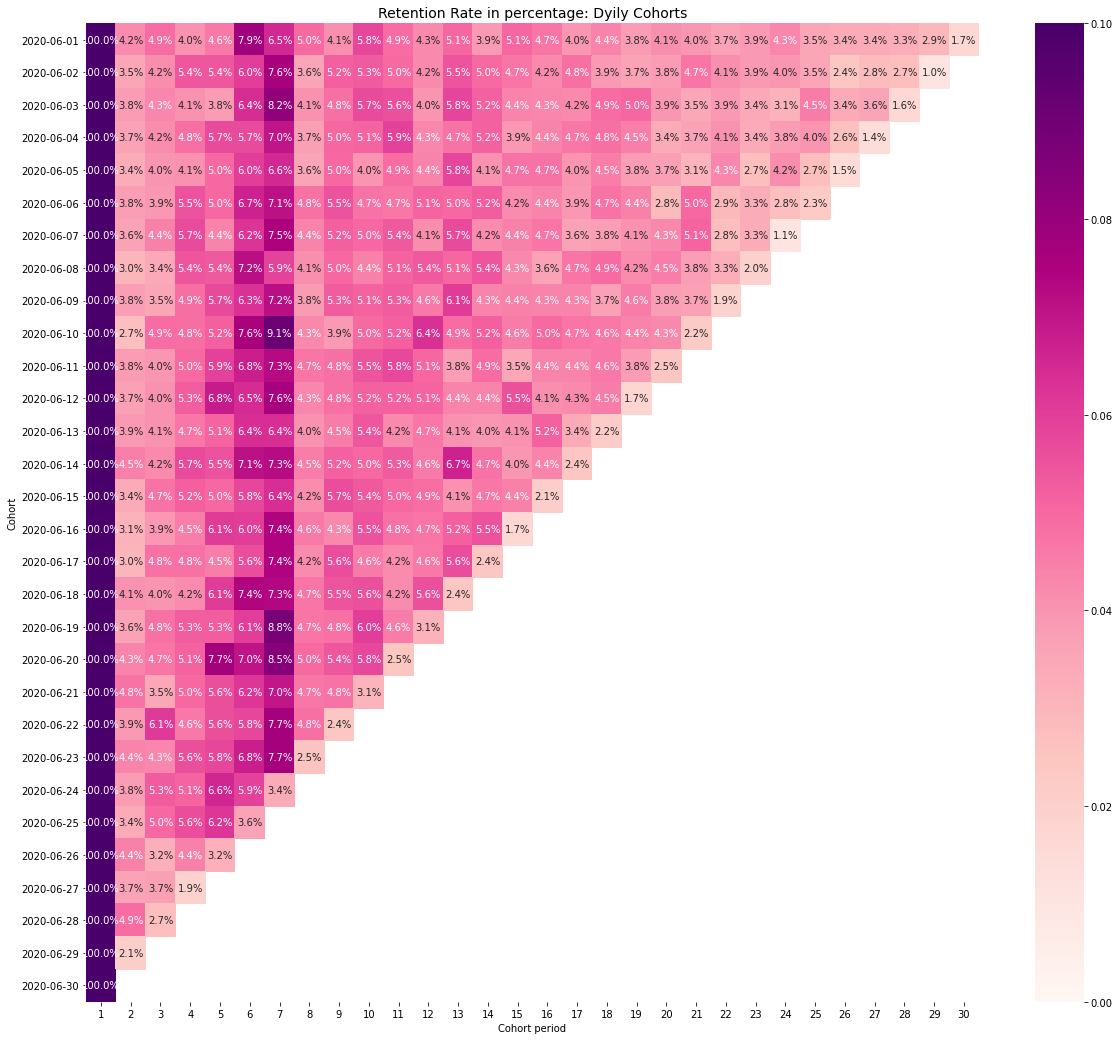

In [12]:
retention_rate(full_data, '2020-06-01', 30)

Так, например, retention 3 дня, для пользователей, зарегистрировавшихся 24 июня 2020 года составляет 5.3%

# Задание 2

In [13]:
ab_data = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/12gk_ATEeBZm4A', sep = ';')

In [14]:
ab_data.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [15]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


группа a - контрольная  
группа b - тестовая

In [16]:
indicators = ab_data.groupby('testgroup', as_index = False) \
                    .agg({'user_id':'count', 'revenue':'sum'}) \
                    .rename(columns = {'user_id':'users'})

In [42]:
customers = ab_data[ab_data.revenue > 0].groupby('testgroup', as_index = False) \
                    .agg({'user_id':'count'}) \
                    .rename(columns = {'user_id':'customers'})

In [18]:
indicators = indicators.merge(customers, on = 'testgroup')

In [19]:
indicators['ARPU'] = (indicators.revenue / indicators.users).round(2)
indicators['ARPPU'] = (indicators.revenue / indicators.customers).round(2)
indicators['CR'] = (indicators.customers / indicators.users).round(4)

In [20]:
indicators

,testgroup,users,revenue,customers,ARPU,ARPPU,CR
0,a,202103,5136189,1928,25.41,2664.00,0.0095
1,b,202667,5421603,1805,26.75,3003.66,0.0089


Как видно из таблицы, в тестовой группе значения ARPU и ARPPU больше значений этих показателей в контрольной группе. Однако, насколько значимы эти различия нам только предстоит выяснить.

In [21]:
control = ab_data[ab_data.testgroup == 'a']
test = ab_data[ab_data.testgroup == 'b']

Проверим наши выборочные данные на нормальность распределения с помощью теста д'Агостино.  
H0: распределение выборочшых данных не отличается от нормального  
H1: распределение выборочшых данных отличается от нормального

In [22]:
stats.normaltest(control.revenue)

NormaltestResult(statistic=585152.7312728433, pvalue=0.0)

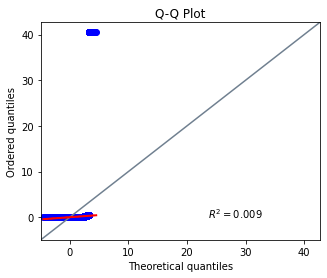

In [23]:
pg.qqplot(control.revenue)

In [24]:
stats.normaltest(test.revenue)

NormaltestResult(statistic=326622.39540856465, pvalue=0.0)

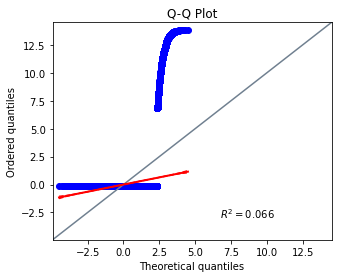

In [25]:
pg.qqplot(test.revenue)

И для контрольной и для тестовой группы мы отклоняем нулевую гипотезу => оба распределения не соответсвуют нормальному. 
Для дальнейшего нализа данных буду использовать Бутстрап. Так как он позволит сосредоточится именно на проверке равенства
средних значений воборок.

In [43]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin = 0,ymax = 50,linestyle = '--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"p_value": p_value}

Далее бутстрапом проверим гипотезы о равенстве средних значений (соответсвует ARPU):  
H0: различий между средними значениями контрольной и тестовой групп нет.  
H1: есть статистически значимые различия между средними контрольной и тестовой групп.

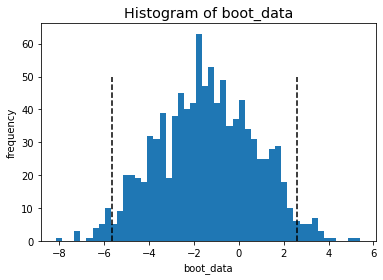

{'p_value': 0.5149132322105424}

In [27]:
get_bootstrap(
    control.revenue,
    test.revenue,
    boot_it = 1000,
    statistic = np.mean,
    bootstrap_conf_level = 0.95)

На получившейся гисторгамме в рассчитанный доверительный интервал попал 0, что не позволяет отклонить Н0, которая говорит о том, что различий между значениями ARPU контрольной и тестовой групп нет. Также о необходимости принятия нулевой гипотезы говорит и p_value, значение которого превышает 0.05.

Аналогичную проверку проведем для ARPPU, а также медианного значени показателя дохода среди платящих пользователей.

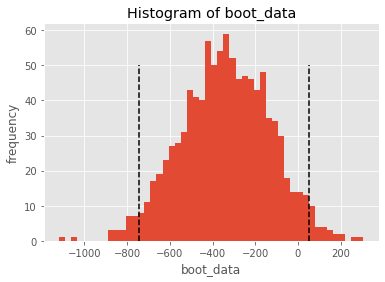

{'p_value': 0.10319883189244512}

In [28]:
get_bootstrap(
    control[control.revenue > 0].revenue,
    test[test.revenue > 0].revenue,
    boot_it = 1000,
    statistic = np.mean,
    bootstrap_conf_level = 0.95)

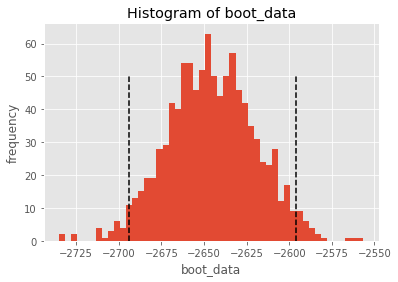

{'p_value': 0.0}

In [29]:
get_bootstrap(
    control[control.revenue > 0].revenue,
    test[test.revenue > 0].revenue,
    boot_it = 1000,
    statistic = np.median,
    bootstrap_conf_level = 0.95)

В случае со значением ARPPU статистически значимых различий между контрольной и тестовой группами выявлено не было. Но противополжная ситуация наблюдается с медианным значением показателя дохода среди платящих пользователей. Значение p меньше 0.05 и на получившейся гисторгамме в рассчитанный доверительный интервал 0 не попал, что дает нам право отклонить Н0 об отсутствии различий между значениями медиан в контрольной и тестовой группах.

In [38]:
control[control.revenue > 0].revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [39]:
test[test.revenue > 0].revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

Значение медианы в тестовой группе практически в 10 раз превышает значение мадианы контрольной. Это говорит о том, что в тестовой группе большее число пользователей совершает "покупки" на большие суммы.

Проанализируем еще один показатель CR (Conversion Rate). Для этого будем использовать хи-квадрат.  
H0: Вид набора акционных предложений не оказывает влияния на уровень конверсии  
Н1: Уровень конверсии зависит от вида набора акционных предложений (a или b)

In [120]:
control_size = indicators[indicators.testgroup == 'a'].users
a_paying = indicators[indicators.testgroup == 'a'].customers
a_not_paying = control_size - a_paying
test_size = indicators[indicators.testgroup == 'b'].users
b_paying = indicators[indicators.testgroup == 'b'].customers
b_not_paying = test_size - b_paying

table = [[a_paying, a_not_paying],
        [b_paying, b_not_paying]]

In [121]:
stat, p, dof, expected = stats.chi2_contingency(table)
prob = 0.95
critical = stats.chi2.ppf(prob, dof)
print(f'Расчетное зачение хи-квадрат равно: {stat.round(3)}')
print(f'Критическое зачение хи-квадрат равно: {critical.round(3)}')
print(f'Значение p равно: {p.round(3)}')

Расчетное зачение хи-квадрат равно: 4.375
Критическое зачение хи-квадрат равно: 3.841
Значение p равно: 0.036


Полученное расчетное значение статистики больше критического, а p меньше 0.05. На основании этого отклоняем нулевую гипотезу и можем сделать вывод, что вид набора акционных предложений влияет на значение CR.

В результате анализа была выявлено, что вид набора акционных предложений не оказывает статистически значимого влияния на ARPU и ARPPU. Статистически значимы оказались Conversion Rate и Медианный доход, приносимы платящими пользователями. В контрольной группе CR немного выше чем в тестовой. В целом, результаты получились довольно протеворечивыми. Оновываясь на СR набор акционных предложений группы а можно считать лучшим, но, если ориентироваться на медианный доход, то лучшим следует признать вариант b.
Если опираться только на эти данные, то, на мой взгляд, остановиться лучше на виде акции группы b, так как суммы трат пользователей в этом случае более равномерно распределены и, если кто-то из пользователей перестанет платить, это не так существенно повлияет на финансовые показатели.

# Задание 3

Метрики для оценки результатов последнего прошедшего события:
* __ARPU__
* __Conversion Rate(CR)__ - как отношение количетва пользователей, присоединившихся к тематическому событию, к количеству пользователей заходивших в игру в данный период.
* __Retention rate__ для пользователей, присоединившихся к событию. 
* __DAU__
* __Average Number of Sessions__
* __Average Session Length__
* __Ad Gross__  

Если рассматриват вариант, при котором игрок будет откатываться на несколько уровней назад при каждой неудачной попытке выполнения уровня, то, на мой взгляд, особое внимание, помимо показптелей, перечисленных выше, следует обратить на __Churn rate__.